# LLM - XLM-RoBERTa

XLM-RoBERTa (Cross-lingual Language Model RoBERTa) is an extension of the RoBERTa model designed by Facebook AI to handle multiple languages. It builds upon the multilingual BERT framework, enhancing cross-lingual understanding and performance. XLM-RoBERTa is trained on a massive dataset that spans over 100 languages.

The objective of this Notebook is to evaluate XLM-RoBERTa's performance on the ISEAR dataset. The evaluation focuses on XLM-RoBERTa's ability to classify emotions accurately within the dataset, analyzing its effectiveness in understanding and categorizing emotional expressions in text data.


## Libraries


In [18]:
import transformers
from transformers import (
    AutoTokenizer,
    set_seed,
    pipeline,
    DataCollatorWithPadding,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    AutoModel,
)
from datasets import Dataset, DatasetDict, ClassLabel
import pandas as pd
import numpy as np
import evaluate
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
)
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

## Dataset

Se cargan los datasets de `training`, `validation` y `test`. Se utiliza cada uno para:

- `training` = Realizar el fine tunning del modelo.
- `validation` = validar el proceso de fine tunning.
- `test` = testear el modelo con nuevos datos.


In [4]:
df_train = pd.read_csv("../data/data_to_model/train_data.csv").rename(
    columns={"emotion": "label"}
)
df_val = pd.read_csv("../data/data_to_model/val_data.csv").rename(
    columns={"emotion": "label"}
)
df_test = pd.read_csv("../data/data_to_model/test_data.csv").rename(
    columns={"emotion": "label"}
)

### Consolidating training, validation y test:


In [5]:
# Convert the pandas DataFrame into a Dataset
df_dict_train = Dataset.from_pandas(df_train)
df_dict_train = df_dict_train.class_encode_column("label")

df_dict_val = Dataset.from_pandas(df_val)
df_dict_val = df_dict_val.class_encode_column("label")

df_dict_test = Dataset.from_pandas(df_test)
df_dict_test = df_dict_test.class_encode_column("label")


# Crear el DatasetDict con train, validation y test
emotions = DatasetDict(
    {
        "train": df_dict_train,
        "validation": df_dict_val,
        "test": df_dict_test,
    }
)


# Verificar el resultado
emotions

Casting to class labels:   0%|          | 0/6027 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/753 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/754 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6027
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 753
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 754
    })
})

## Fine-tuning `Roberta-base`


### Tokenize Text


In [12]:
tokenizer = AutoTokenizer.from_pretrained(
    "FacebookAI/xlm-roberta-base", clean_up_tokenization_spaces=True
)

print("The vocabulary size is:", tokenizer.vocab_size)
print("Maximum context size:", tokenizer.model_max_length)
print(
    "Name of the fields, model need in the forward pass:", tokenizer.model_input_names
)

The vocabulary size is: 250002
Maximum context size: 512
Name of the fields, model need in the forward pass: ['input_ids', 'attention_mask']


In [13]:
# Tokenize
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=False)

In [14]:
tokenize(emotions["train"][:2])

{'input_ids': [[0, 3229, 70, 5895, 100, 42276, 7, 21449, 17, 4163, 158200, 237, 47, 3642, 17, 2806, 36461, 133, 70, 17582, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 17, 509, 198465, 3229, 17, 49782, 70, 108, 6958, 38648, 7, 91, 114382, 214, 4, 17, 280, 13, 20051, 8305, 70, 76896, 136, 24124, 10, 6117, 4240, 31577, 47, 30957, 759, 108, 6958, 38648, 25, 7, 18276, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [15]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/754 [00:00<?, ? examples/s]

In [16]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

### Analyzing encoded text


In [19]:
model_ckpt = "FacebookAI/xlm-roberta-base"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [20]:
def extract_hidden_states(batch):
    inputs = {
        k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names
    }
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

In [21]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
print(type(emotions_encoded["train"]["input_ids"]))

<class 'torch.Tensor'>


In [22]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/754 [00:00<?, ? examples/s]

In [23]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden state']

In [24]:
X_train = np.array(emotions_hidden["train"]["hidden state"])
X_valid = np.array(emotions_hidden["validation"]["hidden state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
print(X_train.shape, X_valid.shape)

(6027, 768) (753, 768)


### PCA


In [25]:
pca = PCA(n_components=2)

x_scaled = MinMaxScaler().fit_transform(X_train)
x_2d = pca.fit_transform(x_scaled)
x_2d.shape

(6027, 2)

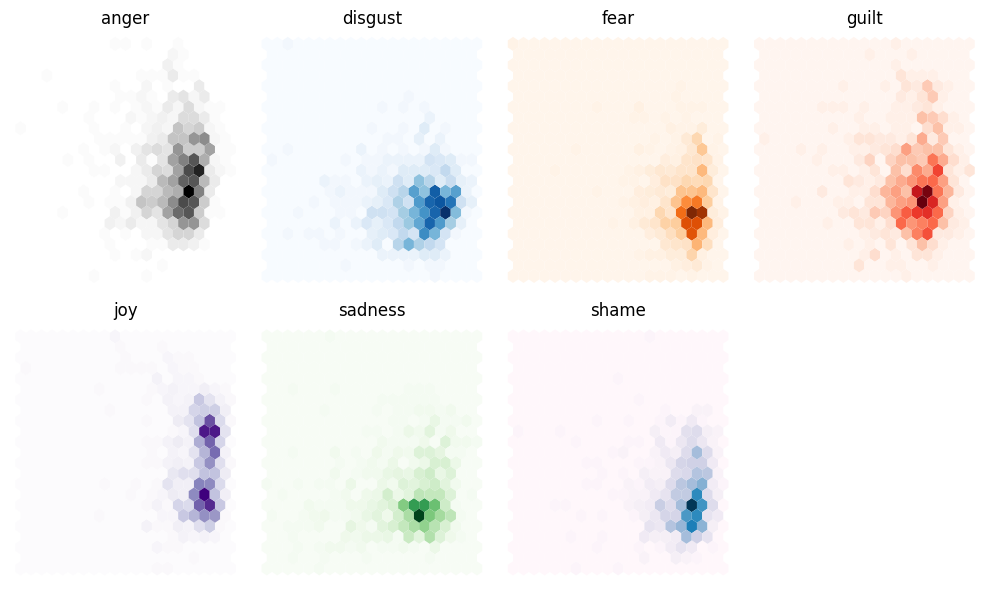

In [26]:
fig, ax = plt.subplots(2, 4, figsize=(10, 6))
ax = ax.flatten()

# Ensure we have enough colormaps for all labels
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens", "PuBu"]
labels = emotions["train"].features["label"].names

# Plot for each label
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_2d_sub = x_2d[y_train == i]
    ax[i].hexbin(
        x_2d_sub[:, 0], x_2d_sub[:, 1], cmap=cmap, gridsize=20, linewidths=(0,)
    )
    ax[i].set_title(label)
    ax[i].set_axis_off()

# Hide the extra subplot (8th one) if it exists
if len(ax) > len(labels):
    ax[-1].set_visible(False)

plt.tight_layout()
plt.show()

### Base Models with tokenized Data


In [27]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.5325365205843293

In [28]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")  # Predict the most frequent
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.14475431606905712

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    _, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

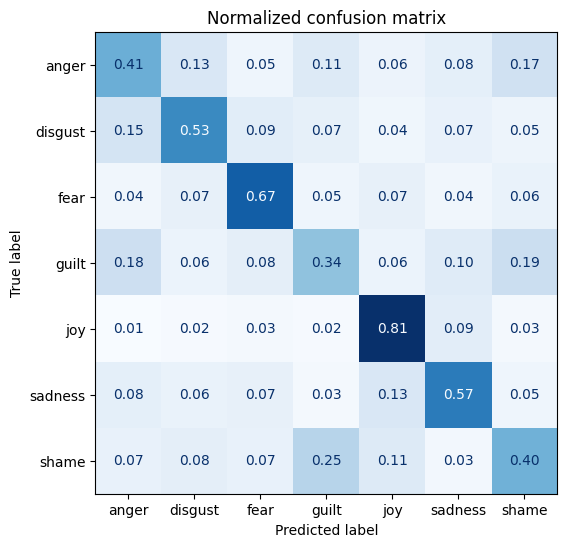

In [30]:
y_pred = lr_clf.predict(X_valid)
plot_confusion_matrix(y_pred, y_valid, labels)

### Fine-tuning


In [31]:
num_labels = 7
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=num_labels
).to(device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [33]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-isear"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    disable_tqdm=False,
    logging_steps=logging_steps,
    log_level="error",
    report_to="none",
)

In [34]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.730200,1.296355,0.548473,0.532227
2,1.213200,1.023434,0.661355,0.654642
3,0.959900,0.942404,0.683931,0.684893
4,0.799700,0.941853,0.683931,0.685977
5,0.673900,0.957389,0.673307,0.674410
6,0.601700,0.957690,0.686587,0.685510
7,0.528400,0.989377,0.686587,0.686307
8,0.464700,1.018793,0.693227,0.692508
9,0.417800,1.018288,0.697211,0.697177
10,0.400400,1.028784,0.689243,0.689140


TrainOutput(global_step=950, training_loss=0.7752573776245117, metrics={'train_runtime': 1932.0846, 'train_samples_per_second': 31.194, 'train_steps_per_second': 0.492, 'total_flos': 2323010039962500.0, 'train_loss': 0.7752573776245117, 'epoch': 10.0})

In [35]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [36]:
preds_output.metrics

{'test_loss': 0.9418533444404602,
 'test_accuracy': 0.6839309428950863,
 'test_f1': 0.6859771909573262,
 'test_runtime': 2.9773,
 'test_samples_per_second': 252.917,
 'test_steps_per_second': 4.031}

In [37]:
y_preds = np.argmax(preds_output.predictions, axis=1)

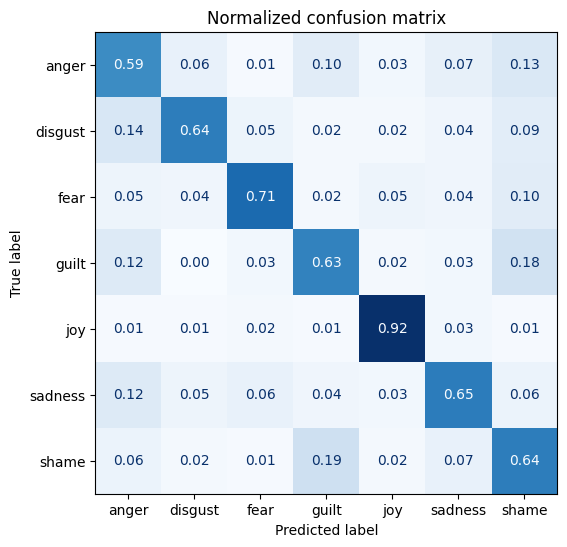

In [38]:
plot_confusion_matrix(y_preds, y_valid, labels)

## Predictions on test dataset


In [39]:
emotions_hidden["test"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden state']

In [40]:
# Evaluar el modelo en el conjunto de prueba
test_results = trainer.evaluate(eval_dataset=emotions_hidden["test"])

# Imprimir los resultados de las métricas en el conjunto de prueba
test_results

{'eval_loss': 0.8420397043228149,
 'eval_accuracy': 0.7015915119363395,
 'eval_f1': 0.7016398243382986,
 'eval_runtime': 3.2329,
 'eval_samples_per_second': 233.225,
 'eval_steps_per_second': 3.712,
 'epoch': 10.0}

In [41]:
preds_output = trainer.predict(emotions_encoded["test"])

In [42]:
y_pred_test = np.argmax(preds_output.predictions, axis=1)
len(y_pred_test)

754

In [43]:
preds_output.metrics

{'test_loss': 0.8420397043228149,
 'test_accuracy': 0.7015915119363395,
 'test_f1': 0.7016398243382986,
 'test_runtime': 2.8252,
 'test_samples_per_second': 266.886,
 'test_steps_per_second': 4.248}

In [44]:
y_test = np.array(emotions_hidden["test"]["label"])
len(y_test)

754

Classification Report:
              precision    recall  f1-score   support

       anger       0.55      0.63      0.59       109
     sadness       0.71      0.66      0.69       107
       shame       0.82      0.75      0.78       109
       guilt       0.63      0.68      0.65       106
     disgust       0.85      0.96      0.91       109
        fear       0.81      0.67      0.73       108
         joy       0.56      0.55      0.56       106

    accuracy                           0.70       754
   macro avg       0.71      0.70      0.70       754
weighted avg       0.71      0.70      0.70       754



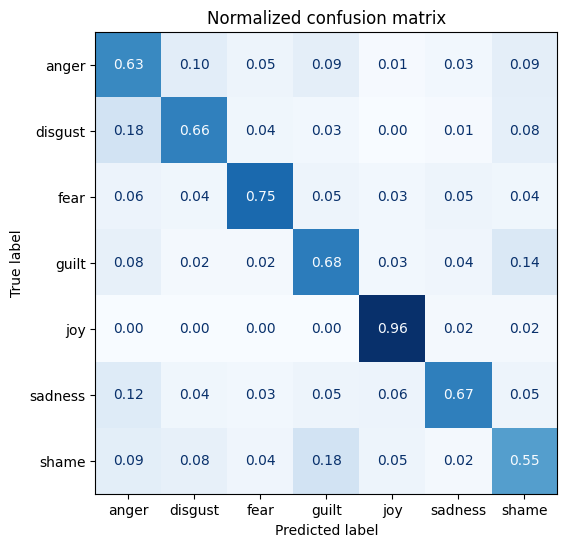

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,FacebookAI/xlm-roberta-base,Fine Tuning,0.701592,0.705619,0.700751,0.700876


In [45]:
# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    y_test,
    y_pred_test,
    output_dict=True,
    target_names=df_test["label"].unique(),
)
print(
    classification_report(
        y_test,
        y_pred_test,
        target_names=df_test["label"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": model_ckpt,
        "Method": "Fine Tuning",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

plot_confusion_matrix(y_pred_test, y_test, labels)

results_df

## Fine- Tuning `xlm-roberta-large`


### Tokenize Text


In [46]:
tokenizer = AutoTokenizer.from_pretrained(
    "FacebookAI/xlm-roberta-large", clean_up_tokenization_spaces=True
)

print("The vocabulary size is:", tokenizer.vocab_size)
print("Maximum context size:", tokenizer.model_max_length)
print(
    "Name of the fields, model need in the forward pass:", tokenizer.model_input_names
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

The vocabulary size is: 250002
Maximum context size: 512
Name of the fields, model need in the forward pass: ['input_ids', 'attention_mask']


In [47]:
# Tokenize
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=False)

In [48]:
tokenize(emotions["train"][:2])

{'input_ids': [[0, 3229, 70, 5895, 100, 42276, 7, 21449, 17, 4163, 158200, 237, 47, 3642, 17, 2806, 36461, 133, 70, 17582, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 17, 509, 198465, 3229, 17, 49782, 70, 108, 6958, 38648, 7, 91, 114382, 214, 4, 17, 280, 13, 20051, 8305, 70, 76896, 136, 24124, 10, 6117, 4240, 31577, 47, 30957, 759, 108, 6958, 38648, 25, 7, 18276, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [49]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/754 [00:00<?, ? examples/s]

In [50]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

### Analyzing encoded text


In [51]:
model_ckpt = "FacebookAI/xlm-roberta-large"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

In [52]:
def extract_hidden_states(batch):
    inputs = {
        k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names
    }
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

In [53]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
print(type(emotions_encoded["train"]["input_ids"]))

<class 'torch.Tensor'>


In [54]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/6027 [00:00<?, ? examples/s]

Map:   0%|          | 0/753 [00:00<?, ? examples/s]

Map:   0%|          | 0/754 [00:00<?, ? examples/s]

In [55]:
X_train = np.array(emotions_hidden["train"]["hidden state"])
X_valid = np.array(emotions_hidden["validation"]["hidden state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
print(X_train.shape, X_valid.shape)

(6027, 1024) (753, 1024)


### PCA


In [56]:
pca = PCA(n_components=2)

x_scaled = MinMaxScaler().fit_transform(X_train)
x_2d = pca.fit_transform(x_scaled)
x_2d.shape

(6027, 2)

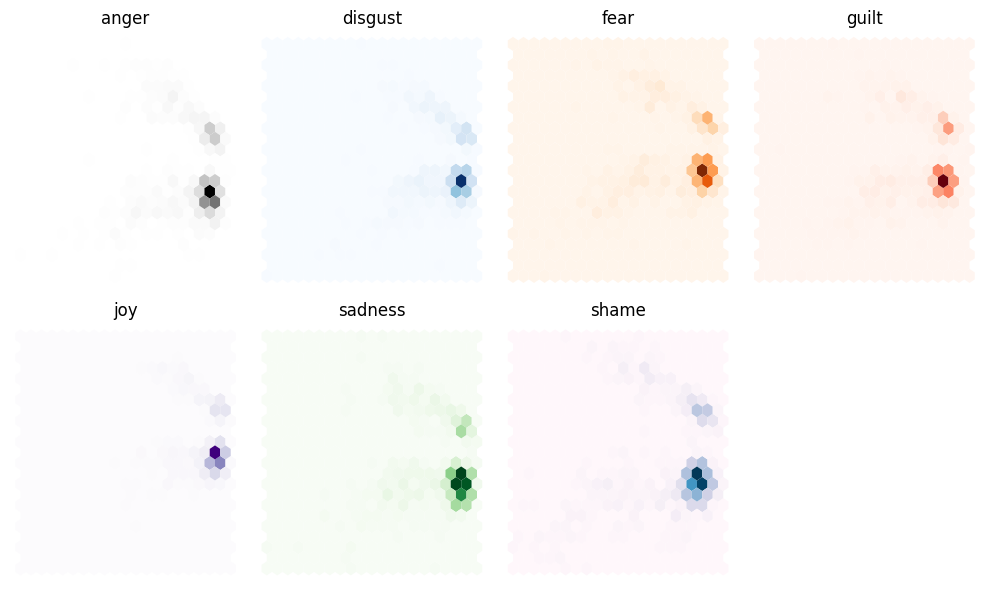

In [57]:
fig, ax = plt.subplots(2, 4, figsize=(10, 6))
ax = ax.flatten()

# Ensure we have enough colormaps for all labels
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens", "PuBu"]
labels = emotions["train"].features["label"].names

# Plot for each label
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_2d_sub = x_2d[y_train == i]
    ax[i].hexbin(
        x_2d_sub[:, 0], x_2d_sub[:, 1], cmap=cmap, gridsize=20, linewidths=(0,)
    )
    ax[i].set_title(label)
    ax[i].set_axis_off()

# Hide the extra subplot (8th one) if it exists
if len(ax) > len(labels):
    ax[-1].set_visible(False)

plt.tight_layout()
plt.show()

### Fine-tuning


In [58]:
num_labels = 7
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=num_labels
).to(device)

In [59]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [60]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-isear"

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    disable_tqdm=False,
    logging_steps=logging_steps,
    log_level="error",
    report_to="none",
)

In [61]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.873200,1.275595,0.536521,0.510792
2,1.057800,0.890778,0.714475,0.711681
3,0.774000,0.841181,0.727756,0.729787
4,0.627300,0.797807,0.741036,0.741471
5,0.518800,0.796278,0.749004,0.750131


TrainOutput(global_step=475, training_loss=0.9664864289133173, metrics={'train_runtime': 10616.5417, 'train_samples_per_second': 2.838, 'train_steps_per_second': 0.045, 'total_flos': 4113900304589250.0, 'train_loss': 0.9664864289133173, 'epoch': 5.0})

In [62]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [63]:
preds_output.metrics

{'test_loss': 0.796278178691864,
 'test_accuracy': 0.749003984063745,
 'test_f1': 0.7501308094095345,
 'test_runtime': 8.2011,
 'test_samples_per_second': 91.817,
 'test_steps_per_second': 1.463}

In [64]:
y_preds = np.argmax(preds_output.predictions, axis=1)

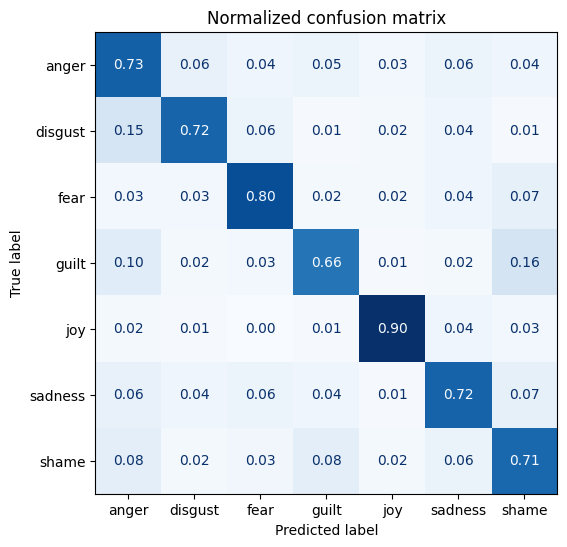

In [65]:
plot_confusion_matrix(y_preds, y_valid, labels)

### Predictions on test dataset


In [66]:
# Evaluar el modelo en el conjunto de prueba
test_results = trainer.evaluate(eval_dataset=emotions_hidden["test"])

# Imprimir los resultados de las métricas en el conjunto de prueba
test_results

{'eval_loss': 0.7548445463180542,
 'eval_accuracy': 0.7453580901856764,
 'eval_f1': 0.7451646841810416,
 'eval_runtime': 10.3082,
 'eval_samples_per_second': 73.146,
 'eval_steps_per_second': 1.164,
 'epoch': 5.0}

In [67]:
preds_output = trainer.predict(emotions_encoded["test"])

In [68]:
y_pred_test = np.argmax(preds_output.predictions, axis=1)
len(y_pred_test)

754

In [69]:
preds_output.metrics

{'test_loss': 0.7548445463180542,
 'test_accuracy': 0.7453580901856764,
 'test_f1': 0.7451646841810416,
 'test_runtime': 10.0415,
 'test_samples_per_second': 75.089,
 'test_steps_per_second': 1.195}

In [70]:
y_test = np.array(emotions_hidden["test"]["label"])
len(y_test)

754

Classification Report:
              precision    recall  f1-score   support

       anger       0.66      0.69      0.68       109
     sadness       0.71      0.72      0.72       107
       shame       0.79      0.83      0.81       109
       guilt       0.71      0.71      0.71       106
     disgust       0.94      0.94      0.94       109
        fear       0.78      0.74      0.76       108
         joy       0.60      0.58      0.59       106

    accuracy                           0.75       754
   macro avg       0.74      0.74      0.74       754
weighted avg       0.75      0.75      0.75       754



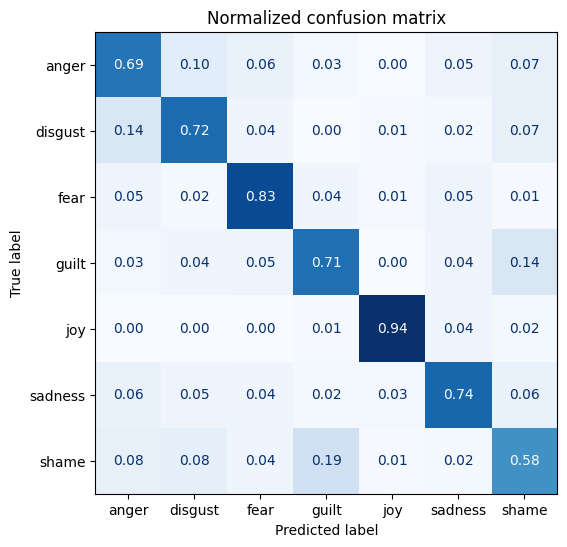

,Model,Method,Test Accuracy,Test Macro Precision,Test Macro Recall,Test Macro F1-Score
0,FacebookAI/xlm-roberta-base,Fine Tuning,0.701592,0.705619,0.700751,0.700876
0,FacebookAI/xlm-roberta-large,Fine Tuning,0.745358,0.744710,0.744505,0.744379
0,FacebookAI/xlm-roberta-large,Fine Tuning,0.745358,0.744710,0.744505,0.744379
0,FacebookAI/xlm-roberta-large,Fine Tuning,0.745358,0.744710,0.744505,0.744379


In [73]:
# Initialize an empty list to store results
results = []

# Step 1: Classification metrics
print("Classification Report:")
report = classification_report(
    y_test,
    y_pred_test,
    output_dict=True,
    target_names=df_test["label"].unique(),
)
print(
    classification_report(
        y_test,
        y_pred_test,
        target_names=df_test["label"].unique(),
    )
)

# Extract important metrics from the classification report for the test set
accuracy = report["accuracy"]
macro_precision = report["macro avg"]["precision"]
macro_recall = report["macro avg"]["recall"]
macro_f1 = report["macro avg"]["f1-score"]

# Store the metrics in the results list
results.append(
    {
        "Model": model_ckpt,
        "Method": "Fine Tuning",
        "Test Accuracy": accuracy,
        "Test Macro Precision": macro_precision,
        "Test Macro Recall": macro_recall,
        "Test Macro F1-Score": macro_f1,
    }
)

# Convert results to a DataFrame
results_df = pd.concat([results_df, pd.DataFrame(results)])

plot_confusion_matrix(y_pred_test, y_test, labels)

results_df

In [74]:
results_df.to_excel("../data/model_results/xlm-roberta.xlsx", index=False)